In [193]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve, differential_evolution, minimize
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial, c_s2
from unchanged_values import r, r_au, sD1_log, Ω, T_req

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

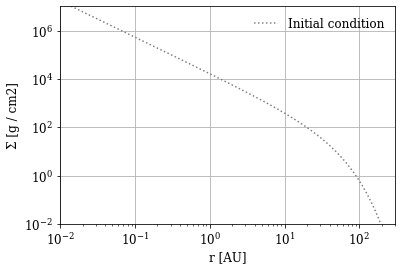

In [194]:
fig, axs = plt.subplots()
axs.grid(ls='-')
axs.loglog(r_au, Σ_initial(r_au), ls=':', c= 'grey', label = 'Initial condition')
axs.set(ylabel = f'Σ [{Σ_initial(r_au).unit}]', xlabel = f'r [{r_au.unit}]', ylim = (1e-2, 1e7), xlim = (1e-2, 3e2));
axs.legend(frameon=False)

### Temperature bith viscous heating and stellar irradiation
$$T^4 = T_{vis}^4 + T_{req}^4$$

### Temperature from irradition
$$T_{1au}=280K\quad p=-1/2$$
$$T_{req}=T_{1au}\left(\frac{r}{1au}\right)^p$$

Text(0.5, 0, 'Distance from star [AU]')

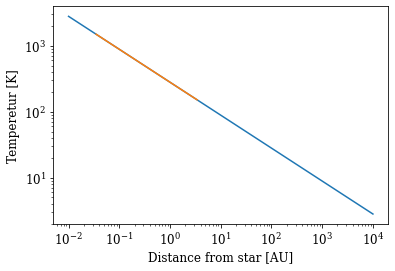

In [195]:
plt.loglog(r, T_req)
plt.loglog(r[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))], T_req[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))])
plt.ylabel('Temperetur [K]')
plt.xlabel('Distance from star [AU]')

Text(0.5, 0, 'Distance from star [AU]')

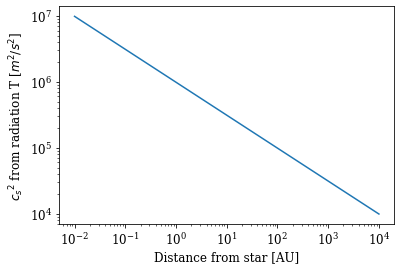

In [196]:
plt.loglog(r, c_s2(T_req)) 
c_s2(T_req).unit, T_req.unit
plt.ylabel('${c_s}^2$ from radiation T [$m^2/s^2$]')
plt.xlabel('Distance from star [AU]')

### Temperature at midplane
$$T_{vis}^4 = \frac{1}{2\sigma_{SB}}\left(\frac{3}{8}\tau_R+\frac{1}{2\tau_P}\right)F_{rad}$$
$$\tau_R=\kappa_R\Sigma/2$$
### $\kappa_R:$
$$\kappa_R = 4.5(T/150K)^2\;cm^2g^{-1}\quad T<150K$$
$$\kappa_R = 4.5\;cm^2g^{-1}\quad 150K \leq T \leq1500K$$
$$\kappa_R = 0\;cm^2g^{-1}\quad 1500K<T$$

$$\tau_P = max(2.4\tau_R,\;0.5)$$
### $F_{rad}$ for the strong DW case (p. 4 Suzuki)
$$F_{rad} = max\left(-\frac{1}{r}\partial_r r^2 \Sigma \Omega α_{rφ} c_s^2,\;0\right)$$
$$[r^2 \Sigma \Omega α_{rφ} c_s^2] = \frac{m^2kg}{s^3}\quad\Rightarrow\quad [F_{rad}]=\frac{kg}{s^3}$$


1 / s
5.6703744191844314e-08 kg / (K4 s3)


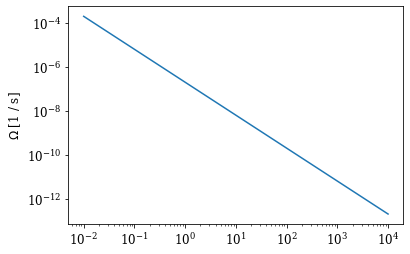

In [197]:
plt.loglog(r, Ω)
plt.ylabel(f'$\Omega$ [{Ω.unit}]')
print(Ω.unit) 
print(sigma_sb.decompose())

Unit("kg m2 / s3")

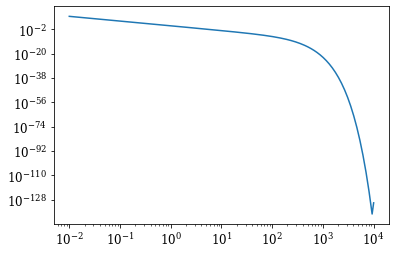

In [198]:
α_rφ = 8e-5
func_to_der = (r_au**2 * Σ_initial(r_au) * Ω * α_rφ * c_s2(T_req)).decompose()
F_rad = (-(r_au**(-2)) * (sD1_log @ func_to_der) * func_to_der.unit).decompose()

plt.loglog(r, F_rad)
F_rad[F_rad < 0]
func_to_der.unit

In [199]:
test = np.array([3])
type(test) == np.ndarray
type(T_req)

astropy.units.quantity.Quantity

In [200]:
### Opacity ###
def tau_R(T, Σ):
    if type(T) != np.ndarray:
        TT = (T.value).copy()
    else:
        TT = T.copy()
    κ = np.zeros_like(TT)

    κ[TT < 150] = 4.5 * (TT[TT < 150] / 150)**2 

    κ[np.where((TT >= 150) & (TT <= 1500))] = 4.5 

    κ[TT > 1500] = 0 # Støvet fordamper og går i stykker 

    return κ * (Σ.to('g/cm2')).value / 2


def tau_P(τ_R):
    τ_P = τ_R.copy()
    τ_P[2.4 * τ_P <= 0.5] = 0.5
    τ_P[τ_P != 0.5] = 2.4 * τ_P[τ_P != 0.5]
    return τ_P

In [201]:
def F_rad_func(Σ, cs2):
    func_to_der = (r_au**2 * Σ * Ω * α_rφ * cs2).decompose()
    F_rad = (-(r_au**(-2)) * (sD1_log @ func_to_der) * func_to_der.unit).decompose()
    F_rad_nounit = F_rad.value
    F_rad_nounit[F_rad_nounit <= 0] = 0
    return F_rad_nounit * F_rad.unit

In [202]:
F_rad_func(Σ_initial(r_au), c_s2(T_req)).to('W/m2') # It's a flux

<Quantity [4.01022652e+007, 3.15159872e+007, 2.47172166e+007,
           1.93850954e+007, 1.52032360e+007, 1.19235019e+007,
           9.35128475e+006, 7.33395746e+006, 5.75181770e+006,
           4.51098553e+006, 3.53783294e+006, 2.77461508e+006,
           2.17604395e+006, 1.70660121e+006, 1.33843061e+006,
           1.04968516e+006, 8.23230767e+005, 6.45629584e+005,
           5.06342630e+005, 3.97104447e+005, 3.11432647e+005,
           2.44243260e+005, 1.91549066e+005, 1.50222994e+005,
           1.17812572e+005, 9.23943947e+004, 7.24599931e+004,
           5.68263200e+004, 4.45655482e+004, 3.49500130e+004,
           2.74090308e+004, 2.14950341e+004, 1.68570115e+004,
           1.32196778e+004, 1.03671370e+004, 8.13007073e+003,
           6.37568929e+003, 4.99985150e+003, 3.92088407e+003,
           3.07473440e+003, 2.41116918e+003, 1.89079295e+003,
           1.48270995e+003, 1.16269036e+003, 9.11732136e+002,
           7.14933147e+002, 5.60606611e+002, 4.39587377e+002,
        

In [203]:
(sigma_sb*(280 *u.K)**4).value

348.5329658998226

348.5329658998226 W / m2


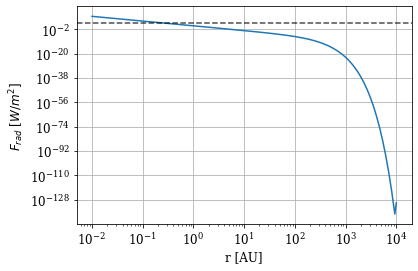

In [204]:
plt.loglog(r, F_rad_func(Σ_initial(r_au), c_s2(T_req)))
plt.grid()
plt.ylabel('$F_{rad}$'+' [$W/m^2$]')
plt.xlabel(f'r [{r_au.unit}]')
print(sigma_sb * (280 *u.K)**4)
plt.axhline((sigma_sb*(280 *u.K)**4).value, alpha = 0.7, ls = '--', c = 'black')
#plt.ylim(1e-10,1e5)
# The offest is due to α_rφ is set to be 3e-5

In [205]:
def T_vis(T, Σ):
    return ((0.5 * sigma_sb**(-1) * (3/8 * tau_R(T, Σ) + 0.5 * tau_P(tau_R(T, Σ))**(-1)) * F_rad_func(Σ, c_s2(T)))**(0.25)).decompose()

In [206]:
T_vis(T_req, Σ_initial(r_au))

<Quantity [4.33642454e+03, 4.08293340e+03, 3.84228396e+03, 3.61581792e+03,
           3.40269933e+03, 3.20214153e+03, 3.01340419e+03, 2.83579063e+03,
           2.66864525e+03, 2.51135105e+03, 2.36332744e+03, 2.22402801e+03,
           2.09293858e+03, 1.96957525e+03, 1.85348268e+03, 1.74423233e+03,
           1.64142092e+03, 1.54466897e+03, 5.59722164e+04, 5.13182642e+04,
           4.70511823e+04, 4.31388130e+04, 3.95516714e+04, 3.62627235e+04,
           3.32471824e+04, 3.04823216e+04, 2.79473038e+04, 2.56230235e+04,
           2.34919634e+04, 2.15380623e+04, 1.97465940e+04, 1.81040565e+04,
           1.65980699e+04, 1.52172836e+04, 1.39512903e+04, 1.27905478e+04,
           1.17263072e+04, 1.07505467e+04, 9.85591142e+03, 9.03565766e+03,
           8.28360242e+03, 7.59407660e+03, 6.96188234e+03, 6.38225383e+03,
           5.85082143e+03, 5.36357869e+03, 4.91685221e+03, 4.50727393e+03,
           4.13175575e+03, 3.78746627e+03, 3.47180944e+03, 3.18240501e+03,
           2.91707057e+03

In [207]:
T_req

<Quantity [2800.        , 2704.47302752, 2612.20512736, 2523.08511047,
           2437.00558122, 2353.86280797, 2273.55659809, 2195.99017717,
           2121.07007246, 2048.70600016, 1978.8107567 , 1911.3001136 ,
           1846.09271597, 1783.10998452, 1722.2760208 , 1663.51751579,
           1606.76366152, 1551.94606579, 1498.99866968, 1447.85766801,
           1398.46143244, 1350.75043717, 1304.66718723, 1260.1561492 ,
           1217.16368428, 1175.63798364, 1135.52900604, 1096.78841743,
           1059.3695328 , 1023.22725987,  988.31804476,  954.59981953,
            922.03195143,  890.57519398,  860.19163968,  830.84467429,
            802.49893275,  775.12025651,  748.67565244,  723.13325299,
            698.46227786,  674.63299687,  651.61669411,  629.38563339,
            607.91302479,  587.17299237,  567.14054298,  547.79153618,
            529.10265511,  511.05137841,  493.61595307,  476.77536822,
            460.50932984,  444.79823624,  429.6231545 ,  414.96579762,
      

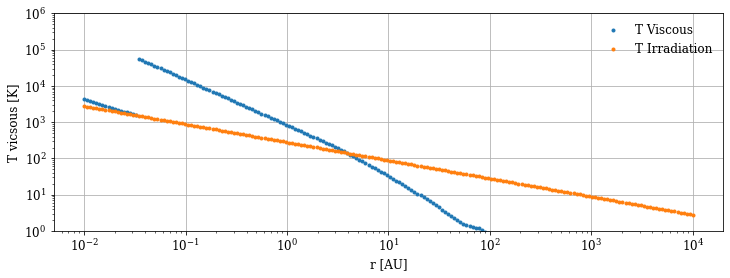

In [208]:
plt.figure(figsize = (12,4))
plt.loglog(r, T_vis(T_req, Σ_initial(r_au)),'.', label = 'T Viscous')
plt.loglog(r, T_req, '.', label = 'T Irradiation')
plt.grid()
plt.ylabel('T vicsous'+f' [{T_vis(T_req, Σ_initial(r_au)).unit}]')
plt.xlabel(f'r [{r_au.unit}]')
plt.ylim(1, 1e6)
plt.legend(frameon = False)
# Falder opaciteten altså den bliver gennemsigtig falder temperaturen fordi der ikke er noget til at holde på varmen

In [209]:
def guess_T(T):
    T_new4 = T_vis(T, Σ_initial(r_au)).value**4 + T_req.value**4
    return T_new4**0.25 * u.K

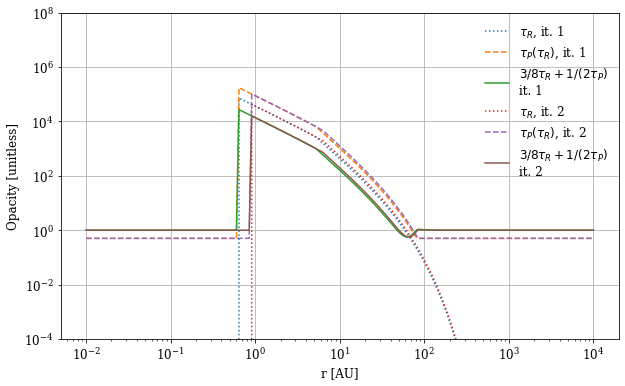

In [222]:
fig, axs = plt.subplots(figsize = (10, 6))

T0 = T_req
T_list = [T_req]
for i in range(2):
    T_new = guess_T(T_list[-1])
    T_damp = (T_list[-1]**4 + T_new**4)**0.25
    T_list.append(T_damp)


axs.grid()
for i, T in enumerate(T_list[1:]):
    axs.loglog(r, tau_R(T, Σ_initial(r_au)), label = f'$τ_R$, it. {i+1}', ls = ':')
    axs.loglog(r, tau_P(tau_R(T, Σ_initial(r_au))), label = f'$τ_P(τ_R)$, it. {i+1}', ls='--')
    axs.set(ylabel = 'Opacity [unitless]', xlabel = 'r [AU]', ylim = (1e-4, 1e8))
    axs.loglog(r, (3/8 * tau_R(T, Σ_initial(r_au)) + 0.5 * tau_P(tau_R(T, Σ_initial(r_au)))**(-1)), label = '$3/8 τ_R + 1/(2τ_P)}$\n'+f'it. {i+1}')
#axs[1].axhline(0.5, c='grey', label = 'τ_P_{min}')
axs.legend(frameon = False)

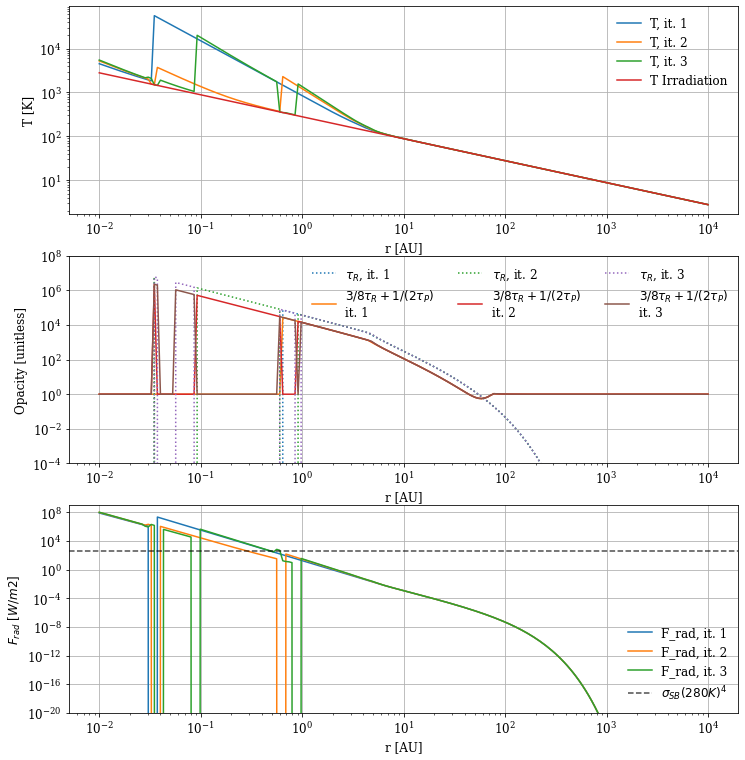

In [211]:
# Opacity check
fig, axs = plt.subplots(3,1, figsize = (12,13))
axs[0].grid()

T1 = guess_T(T_req)
T2 = guess_T(T1)
T3 = guess_T(T2)

for i, T in enumerate([T1, T2, T3]):
    axs[0].loglog(r_au, T, label = f'T, it. {i+1}')
axs[0].loglog(r, T_req, label = 'T Irradiation')
axs[0].set(ylabel = 'T [K]', xlabel = 'r [AU]')
axs[0].legend(frameon =False)

axs[1].grid()
for i, T in enumerate([T1, T2, T3]):
    axs[1].loglog(r, tau_R(T, Σ_initial(r_au)), label = f'$τ_R$, it. {i+1}', ls = ':')
    #axs[1].loglog(r, tau_P(tau_R(T, Σ_initial(r_au))), label = f'$τ_P(τ_R)$, it. {i+1}')
    axs[1].loglog(r, (3/8 * tau_R(T, Σ_initial(r_au)) + 0.5 * tau_P(tau_R(T, Σ_initial(r_au)))**(-1)), label = '$3/8 τ_R + 1/(2τ_P)}$\n'+f'it. {i+1}')
#axs[1].axhline(0.5, c='grey', label = 'τ_P_{min}')

axs[1].set(ylabel = 'Opacity [unitless]', xlabel = 'r [AU]', ylim = (1e-4, 1e8))
axs[1].legend(frameon = False, ncol = 3)


axs[2].grid()
for i, T in enumerate([T1, T2, T3]):
    axs[2].loglog(r, F_rad_func(Σ_initial(r_au), c_s2(T)), label = 'F_rad,'+f' it. {i+1}')
axs[2].set(ylabel = '$F_{rad}$ [$W/m2$]', xlabel = 'r [AU]', ylim = (1e-20, 1e9))
axs[2].axhline((sigma_sb*(280 *u.K)**4).value, alpha = 0.7, ls = '--', c = 'black', label = '$\sigma_{SB}(280K)^4$')
axs[2].legend(frameon = False)

plt.savefig('../graphics/temp_investigation', dpi = 400)


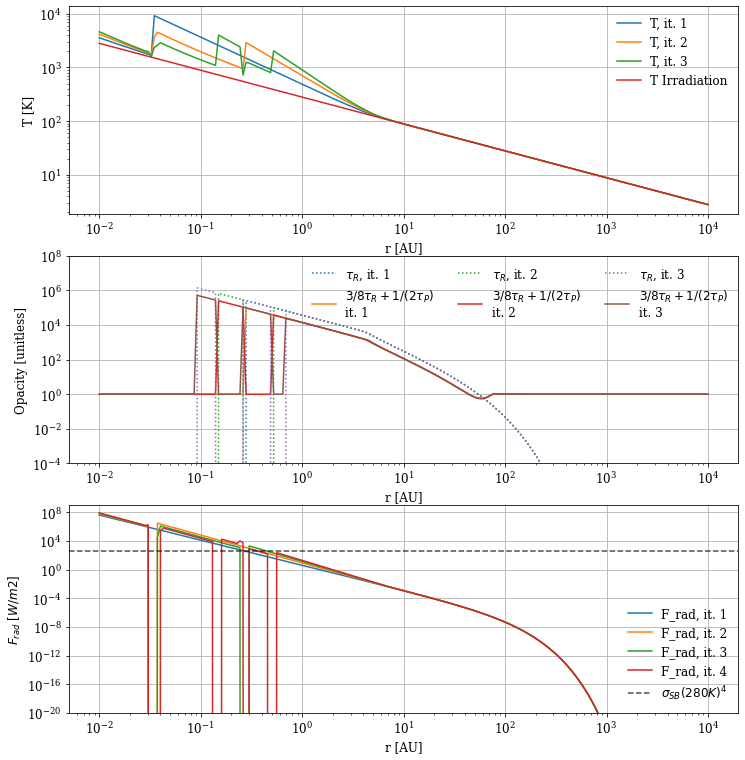

In [223]:
# Opacity check
fig, axs = plt.subplots(3,1, figsize = (12,13))
axs[0].grid()

T0 = T_req
T_list = [T_req]
for i in range(3):
    T_new = guess_T(T_list[-1])
    T_damp = (T_list[-1] * T_new)**0.5
    T_list.append(T_damp)

for i, T in enumerate(T_list[1:]):
    axs[0].loglog(r_au, T, label = f'T, it. {i+1}')
axs[0].loglog(r, T_req, label = 'T Irradiation')
axs[0].set(ylabel = 'T [K]', xlabel = 'r [AU]')
axs[0].legend(frameon =False)

axs[1].grid()
for i, T in enumerate(T_list[1:]):
    axs[1].loglog(r, tau_R(T, Σ_initial(r_au)), label = f'$τ_R$, it. {i+1}', ls = ':')
    #axs[1].loglog(r, tau_P(tau_R(T, Σ_initial(r_au))), label = f'$τ_P(τ_R)$, it. {i+1}')
    axs[1].loglog(r, (3/8 * tau_R(T, Σ_initial(r_au)) + 0.5 * tau_P(tau_R(T, Σ_initial(r_au)))**(-1)), label = '$3/8 τ_R + 1/(2τ_P)}$\n'+f'it. {i+1}')
#axs[1].axhline(0.5, c='grey', label = 'τ_P_{min}')

axs[1].set(ylabel = 'Opacity [unitless]', xlabel = 'r [AU]', ylim = (1e-4, 1e8))
axs[1].legend(frameon = False, ncol = 3)


axs[2].grid()
for i, T in enumerate(T_list):
    axs[2].loglog(r, F_rad_func(Σ_initial(r_au), c_s2(T)), label = 'F_rad,'+f' it. {i+1}')
axs[2].set(ylabel = '$F_{rad}$ [$W/m2$]', xlabel = 'r [AU]', ylim = (1e-20, 1e9))
axs[2].axhline((sigma_sb*(280 *u.K)**4).value, alpha = 0.7, ls = '--', c = 'black', label = '$\sigma_{SB}(280K)^4$')
axs[2].legend(frameon = False)

plt.savefig('../graphics/temp_investigation_damp', dpi = 400)


Text(0.5, 1.0, 'Strong DW and MRI-inactive')

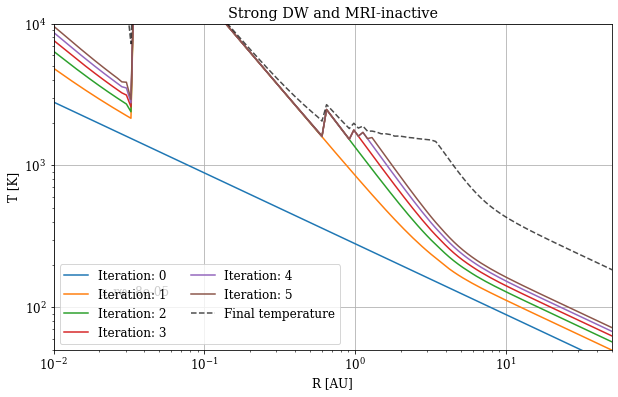

In [228]:
T0 = T_req
T = [T_req]
for i in range(100):
    T_new = guess_T(T[-1])
    T_damp = (T[-1]**3 + T_new**3)**(1/3)
    T.append(T_damp)


plt.figure(figsize = (10,6))
plt.grid()
for i, t in enumerate(T):
    if i <= 5:
        plt.loglog(r, t, label=f'Iteration: {i}')
    #if i%15 == 0:
    #    plt.loglog(r, t, label=f'Iteration: {i}')
plt.loglog(r, T[-1], ls='--', c='black', label = 'Final temperature', alpha = 0.7)
plt.legend(ncol = 2)
plt.ylim(50,1e4)
plt.xlim(0.01, 50)
plt.ylabel(f'T [{T_damp.unit}]')
plt.xlabel('R [AU]')
plt.text(0.02, 1.2e2, f'α_rφ: {α_rφ}')
plt.title('Strong DW and MRI-inactive')

Text(0.5, 0, 'Distance [AU]')

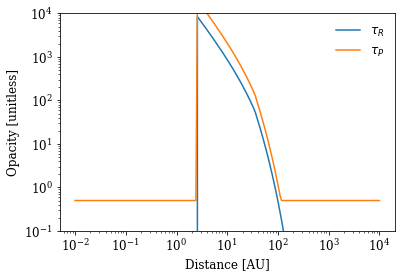

In [214]:
plt.loglog(r, tau_R(T[-1], Σ_initial(r_au)), label = '$τ_R$')
plt.loglog(r, tau_P(tau_R(T[-1], Σ_initial(r_au))), label = '$τ_P$')
plt.ylim(0.1, 1e4)
plt.legend(frameon = False)
plt.ylabel('Opacity [unitless]' )
plt.xlabel('Distance [AU]')